# Bayesian pooled polling charts (Using PyMC)

Note: The Gaussian-Process model seems to be broken. Not sure why.

## Set-up

In [1]:
# system imports
import itertools
from pathlib import Path
from typing import Any, TypedDict, NotRequired

import re

# analytic imports
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
from IPython.display import display

In [2]:
# local import
import bayes_tools
import plotting
from common import MIDDLE_DATE, VOTING_INTENTION, ensure
from data_capture import retrieve

In [3]:
# plotting related
QUICK_PICK: str | None = "grw"  
ACCEPTABLE_QUICK_PICKS = ["fast", "complete", "grw", "gp"]
ensure(QUICK_PICK in ACCEPTABLE_QUICK_PICKS, f"QUICK_PICK={QUICK_PICK} is invalid")

MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

SHOW = True  # show charts in the notebook
SHOW_MODEL_MAPS = False  # show model maps in notebook

DATA_DIR = Path("../data/")
DATA_DIR.mkdir(parents=True, exist_ok=True)

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pymc   : 5.21.0
pandas : 2.2.3
IPython: 9.0.0
re     : 2.2.1
numpy  : 2.2.3

Watermark: 2.5.0



## Get data

In [5]:
def data_check(retrieved: dict[str, Any]) -> dict:
    """Pass the latest data and check it for completeness."""

    ensure(retrieved, "You must run the data capture notebook every day.")
    vi = retrieved[VOTING_INTENTION]
    should_be_complete = ("ALP", "L/NP", "GRN", "OTH")
    check = [x for x in vi.columns if any(y in x for y in should_be_complete)]
    problematic = vi[vi[check].isnull().sum(axis=1) > 0].index
    if problematic.any():
        print(f"Problematic rows: {problematic}")
        display(vi.loc[problematic])

    return retrieved

In [6]:
def last_election() -> pd.Series:
    """Return the results of the last election."""

    previous = pd.read_csv(
        "../historic-data/election-outcomes.csv", sep="\\s+", na_values="-", comment="#"
    )
    previous = previous.dropna(how="all")
    coalition = ["LP", "LNP", "NP", "CLP"]
    previous["Primary vote L/NP"] = previous[coalition].sum(axis=1)
    previous["Primary vote Other"] = (
        100.0 - previous["Primary vote L/NP"] - previous["ALP"] - previous["GRN"]
    )
    previous["Primary vote ALP"] = previous["ALP"]
    previous["Primary vote GRN"] = previous["GRN"]
    previous["2pp vote L/NP"] = 100.0 - previous["Labor2pp"]
    previous["2pp vote ALP"] = previous["Labor2pp"]
    previous["TPP vote ALP"] = previous["2pp vote ALP"]
    previous["TPP vote L/NP"] = previous["2pp vote L/NP"]
    drop_list = [
        "Others",
        "ON",
        "UAP",
        "DEM",
        "DLP",
        "GRN",
        "ALP",
        "Labor2pp",
    ] + coalition
    return previous.drop(columns=drop_list).iloc[-1]

## Prepare for the Bayesian aggregation/pooling ...

### The selection of analyses to undertake

In [7]:
def select_analytic_modality(
    qp: str | None = QUICK_PICK,
) -> list[tuple[bool, str, str]]:
    # pylint: disable=unused-variable
    """
    Select the analutic modalities that will be applied
    to each column in the voting intention data.
    Returns a list of tuples. where each tuple has three
    elements:
     - fixed_prior (True, False)
     - likelihood (Normal, StudentT)
     - approach (GRW, GRWLA, GP)
    """

    # -- the analytic possibilities that can be selected
    fixed_priors = False, True
    likelihoods = "Normal", "StudentT"
    approaches = "GRW", "GRWLA", "GP"

    # -- create a range of options for the analysis
    complete_set = list(itertools.product(fixed_priors, likelihoods, approaches))
    fixed_normal_grw_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GRW"
    ]
    fixed_normal_gp_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GP"
    ]
    fixed_normal_gp_grw = list(  # noqa: F841
        set(fixed_normal_grw_only + fixed_normal_gp_only)
    )
    fixed_studentt_grw_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "StudentT" and x[2] == "GRW"
    ]
    fixed_studentt_gp_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "StudentT" and x[2] == "GP"
    ]
    fixed_studentt_gp_grw = list(  # noqa: F841
        set(fixed_studentt_grw_only + fixed_studentt_gp_only)
    )

    # -- return the selected analysis option
    match qp:
        case item if item in ["fast", "gp"]:
            return fixed_normal_gp_only  # default: fixed_normal_gp_only
        case "complete":
            return fixed_normal_gp_grw
        case "grw":
            return fixed_normal_grw_only
        case _:
            # default case
            return fixed_normal_gp_grw

### Identify columns to analyze and plot

In [8]:
def select_columns(df: pd.DataFrame, qp: str | None = QUICK_PICK) -> tuple[str, ...]:
    # pylint: disable=unused-variable
    """Select the columns names from voting intention data we will analyze.
    Returns a tuple of column names, each of type str"""

    # -- identify the columns we will analyze ...
    frame = ("TPP", "2pp", "Primary vote")
    columns = sorted([x for x in df.columns if any(item in x for item in frame)])
    majors = ("ALP", "L/NP")
    minors = ("GRN", "Other")
    to_chart = majors + minors

    # -- column options for selected_columns below
    # be careful to turn generator expressions into tuples ..
    all_columns: tuple = tuple(
        c for c in columns if any(item in c for item in to_chart)
    )
    alp_only = tuple(c for c in all_columns if "ALP" in c)  # noqa: F841
    lnp_only = tuple(c for c in all_columns if "L/NP" in c)  # noqa: F841
    tpp_only = tuple(f"2pp vote {x}" for x in majors)  # noqa: F841
    primary_only = tuple(x for x in all_columns if frame[1] in x)  # noqa: F841
    alp_2pp_only = ("2pp vote ALP",)  # noqa: F841
    most_columns = alp_2pp_only + primary_only  # noqa: F841

    # -- return the selected columns
    match qp:
        case "fast":
            return tpp_only
        case item if item in ["complete", "gp", "grw"]:
            return all_columns
        case _:
            # default case
            return most_columns

### Fixed Priors

In [9]:
def establish_fixed_priors() -> dict[str, Any]:
    """Return a dictionary of fixed priors."""

    # a useful bag of fixed priors
    assumed_sample_size = 750  # assume smallish effective sample
    # sizes polling data is way noisier
    # than published sample size suggest.
    return {
        # --- GRW only fixed priors
        "innovation": 0.175,  # only used with GRW
        # --- GP only fixed priors
        "length_scale": 40,
        "eta": 1.6,
        # --- both GP and GRW fixed priors
        "nu": 10,  # used in StudentT likelihood
        "sigma_likelihood": np.sqrt((50.0 * 50.0) / assumed_sample_size),
    }

### Exclusions from the sum-to-zero constraint on house effects

In [10]:
EXCLUDE = True


def establish_exclusions(df: pd.DataFrame, minimum_polls=5) -> list[str]:
    """Return a a list of pollsters to exclude from the sum-to-zero
    constraint over house effects. Pollsters are excluded because they
    have too few polls to be reliable or because they have multiple
    series of polls that are not consistent with each other.
    Arguments:
    - df - the dataframe of the latest polling data
    Returns:
    - a list of pollsters to exclude."""

    exclusions: list[str] = []
    if not EXCLUDE:
        return exclusions

    # -- remove with multiple series (indicated by trailing digits)
    pollsters = df["Brand"].unique()
    pattern = re.compile(r"([^\d]+) (\d+$)")
    for pollster in pollsters:
        if m := re.search(pattern, pollster):
            exclusions.append(m.groups()[0])
        # Note: need to do case where the trailing digit is 3 or greater
    exclusions = list(set(exclusions))

    # -- exclude pollsters with less than minimum_polls
    # This means odd, one-off polls will not effect the positioning
    # of the poll aggregation
    pollster_counts = df["Brand"].value_counts()
    exclude_counts = pollster_counts[pollster_counts < minimum_polls].index.tolist()
    exclusions = list(set(exclusions + exclude_counts))  # ensue no duplicates

    return exclusions

### Sampler settings

In [11]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sample_settings() -> tuple[SampleSettings, SampleSettings]:
    """Return the settings for sampling as a tuple
    of two elements:
    - a dict of settings for the sampling (GRW and GP models)
    - a dict of settings for the sampling (GRWLA model)."""

    # -- for GRW and GP
    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 1_500,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    # -- for GRWLA model, as above with the following chnges
    anchored_settings = settings.copy()
    anchored_settings["draws"] = 5_000  # draws per core
    anchored_settings["nuts"] = {"max_treedepth": 12}

    return settings, anchored_settings

## Do the analysis and produce the plots

In [12]:
def plot_medians(
    medians: dict[str, pd.Series],
    orig_series: pd.Series,
    column: str,
    **kwargs: Any,
) -> dict[str, pd.Series]:
    """Plot all the medians for the same column of input data
    for the selected modes of analysis.
    Add a localised regression to the plots.
    This allows for a simple model comparison
    Returns the dictionary of medians."""

    if not medians:
        # nothing to plot
        return {}

    # -- Add a local regression to the combined plot
    period_days = 150  # days
    loess = plotting.calculate_lowess(
        series=orig_series,
        frac_period=period_days,
    )
    if loess is not None:
        medians[f"{period_days}-day local regression"] = loess

    # -- plot the medians
    _, ax = plotting.initiate_plot()
    styles = plotting.STYLES * 4
    for index, (name, m_series) in enumerate(medians.items()):
        m_series.plot(ax=ax, ls=styles[index], lw=2, label=name)
    ax.axhline(
        y=kwargs["previous_election"][column],
        color="#555555",
        lw=0.75,
        ls="--",
        label="Previous election",
    )
    ax.legend(loc="best", fontsize="xx-small", ncols=2)

    footnotes = {}
    for key, default in plotting.footers.items():
        footnotes[key] = kwargs.get(key, default)

    plotting.finalise_plot(
        ax,
        title=f"Comparison of medians: {column}",
        ylabel="Per cent",
        y50=True,
        concise_dates=True,
        straighten_tl=True,
        **footnotes,
        show=SHOW,
    )

    return medians

In [13]:
def build_model(
    column: str,
    data: pd.DataFrame,
    approach: str,
    likelihood: str,
    fixed_priors: bool,
    **kwargs: Any,
) -> None | tuple[pm.Model, SampleSettings, dict[str, Any]]:
    """Build the model for the selected approach and likelihood.
    Returns either;
    - None (on errror), or
    - the model, the sampling parameters, and the inputs"""

    # -- get the relevant data then select and run the model
    # Note: I could not get the GRW to mix well without specifying innovation.
    #       Similarly, specifying sigma_likelihood is useful.
    keep_fixed = ("innovation", "sigma_likelihood")
    fpd = kwargs["fixed_priors_dict"]
    priors = fpd.copy() if fixed_priors else {x: fpd[x] for x in keep_fixed}
    sampling = (
        kwargs["anchored_sample_args"].copy()
        if approach == "GRWLA"
        else kwargs["sample_args"].copy()
    )

    inputs = bayes_tools.prepare_data_for_analysis(
        data,
        column,
        tail_centred=10 if approach == "GRWLA" else None,
        he_sum_exclusions=kwargs["he_sum_exclusions"],
        verbose=False,
    )

    match approach:
        case "GP":
            # check for unique dates
            print("GP Check unique poll dates: ", inputs["poll_date"].is_unique)
            model = bayes_tools.gp_model(
                inputs,
                **priors,
                likelihood=likelihood,
                grw=False,
                eta_prior="HalfCauchy",  # only used if eta not in **priors
            )
        case "GRW":
            model = bayes_tools.grw_model(inputs, **priors, likelihood=likelihood)
        case "GRWLA":
            model = bayes_tools.grw_la_model(inputs, **priors, likelihood=likelihood)
        case _:
            print(f"Unknown approach: {approach}")
            return None

    return (model, sampling, inputs)

In [14]:
DATA_REPOSITORY = {}


def apply_analyses_to_column(
    column: str,
    analysis_list: list[tuple[bool, str, str]],
    data: pd.DataFrame,
    **kwargs: Any,
) -> dict[str, pd.Series]:
    """Loop through the selected analyses for a specified column.
    For each: generate the model, draw samples, and plot the
    results. Finally, plot the medians for all the analyses.
    Returns a dict of endpoints of the medians for the analysis."""

    median_sets = {}
    decoder = {
        "GRW": "Gaussian Random Walk",
        "GRWLA": "Gaussian Random Walk with Left Anchoring",
        "GP": "Gaussian Process",
    }
    for fixed_priors, likelihood, approach in analysis_list:
        fixed_text = "fixed" if fixed_priors else "free"
        model_title = f"{column} ({approach} {likelihood} {fixed_text})"
        model_name = (
            f"{decoder[approach]} - {likelihood} likelihood - {fixed_text} priors"
        )
        print(model_title)

        built = build_model(column, data, approach, likelihood, fixed_priors, **kwargs)
        if built is None:
            continue
        model, sampling, inputs = built
        bayes_tools.generate_model_map(
            model=model,
            filemame_stem=model_title,
            model_dir=MODEL_DIR,
            display_images=SHOW_MODEL_MAPS,
        )

        idata, glitches = bayes_tools.draw_samples(model, **sampling)

        # extr footnote got 2pp and TPP
        common = {}
        if "2pp" in column:
            common["lfooter"] = plotting.footers["lfooter"] + "2pp=pollster estimate. "
        if "TPP" in column:
            common["lfooter"] = (
                plotting.footers["lfooter"] + "TPP=using primary votes and 2022 preference flows. "
            )

        middle = bayes_tools.plot_std_set(
            inputs,
            idata,
            kwargs["previous_election"][column],
            title_stem=model_title,
            glitches=glitches,
            residuals=kwargs["plot_residuals"],
            show=SHOW,
            **common,
        )
        if middle is not None:
            median_sets[model_name] = middle
            DATA_REPOSITORY[model_title] = middle  # save for later

    # -- summary plot for each column, and returns
    orig_series: pd.Series = pd.Series(data[column].values, index=data[MIDDLE_DATE])
    median_sets = plot_medians(median_sets, orig_series, column, **(kwargs | common))
    endpoints = {k: v.iloc[-1] for k, v in median_sets.items()}

    # -- save medians to file - may be used in estimating state trends
    fixed = {}
    for name, series in median_sets.items():
        series = series[~series.index.duplicated(keep="last")]
        if not isinstance(series.index, pd.PeriodIndex):
            series.index = pd.PeriodIndex(series.index, freq="D")
        fixed[name] = series
    combined = pd.DataFrame(fixed)
    combined.to_csv(DATA_DIR / f"{column.replace('/', '')}-medians.csv")

    return endpoints

In [15]:
def analyse_columns(
    column_list: tuple[str, ...],
    analysis_list: list[tuple[bool, str, str]],
    data: pd.DataFrame,
    **kwargs: Any,
) -> None:
    """Loop over the columns selected for analysis.
    For each column apply the selected analyses."""

    end_points = {}
    for column in column_list:
        end_points[column] = apply_analyses_to_column(
            column, analysis_list, data, **kwargs
        )

    # -- summary table of final results
    ep_table = pd.DataFrame(end_points).round(2)
    display(ep_table)
    print(ep_table.to_html())

## Run the models

In [16]:
GREEN_FLOW = 0.85658789
OTHER_FLOW = 0.46365604

2pp vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2750.0
Divergences: 0


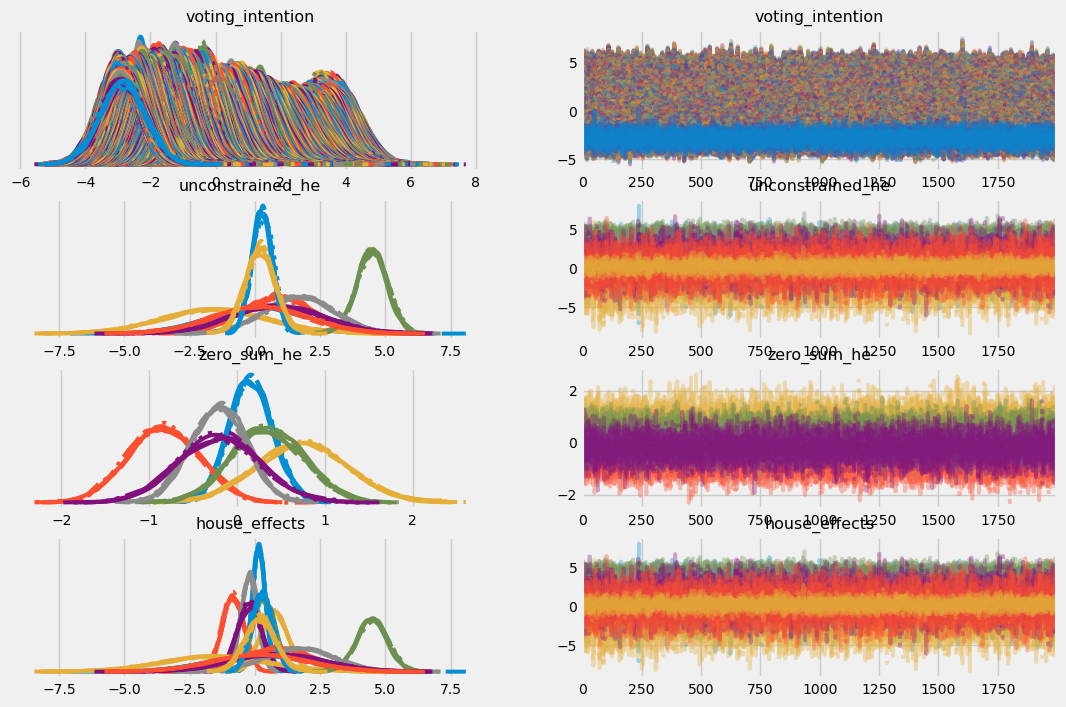

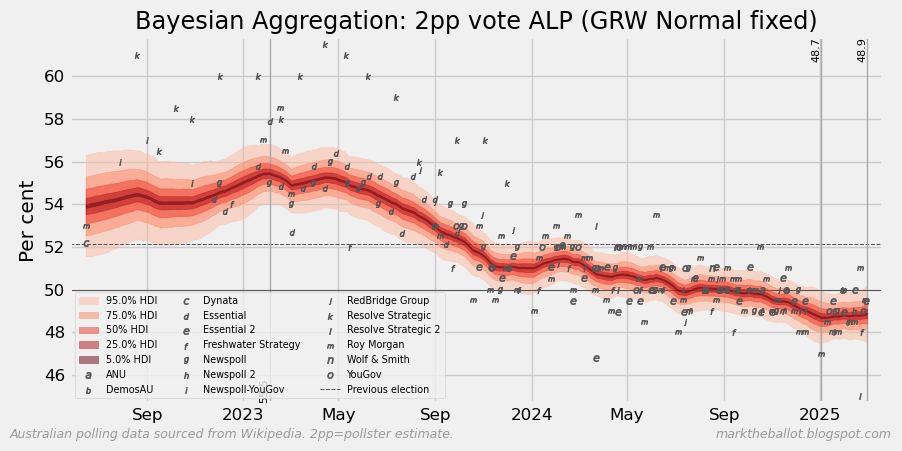

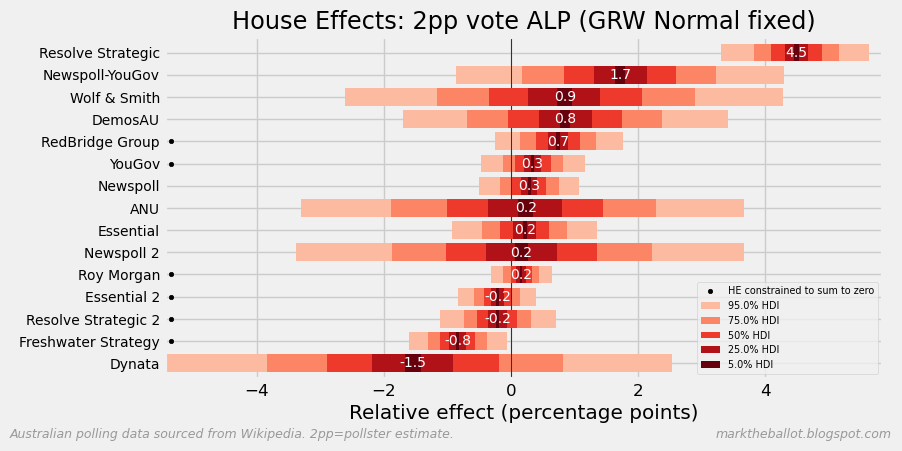

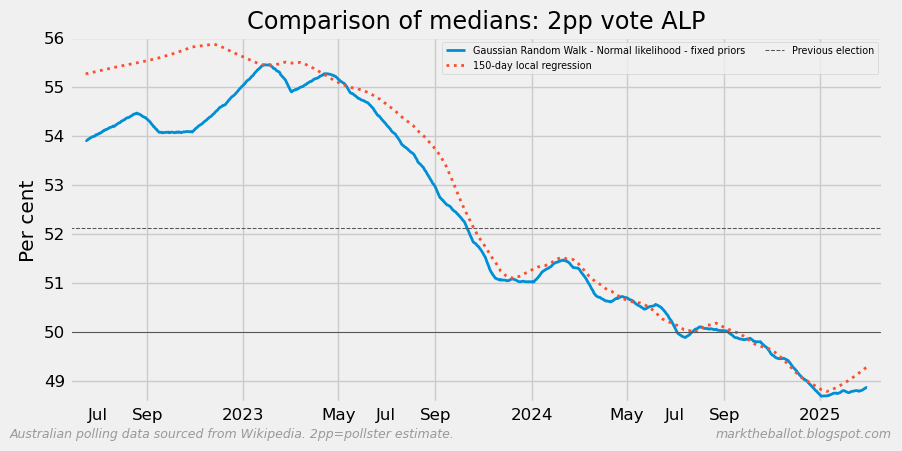

2pp vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3204.0
Divergences: 0


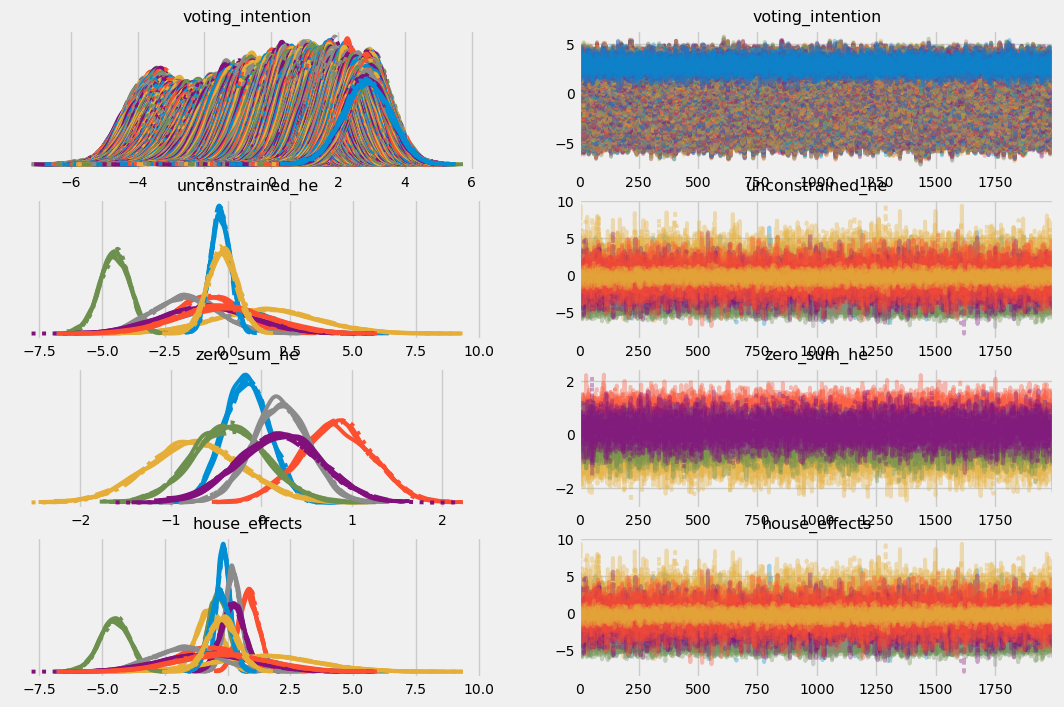

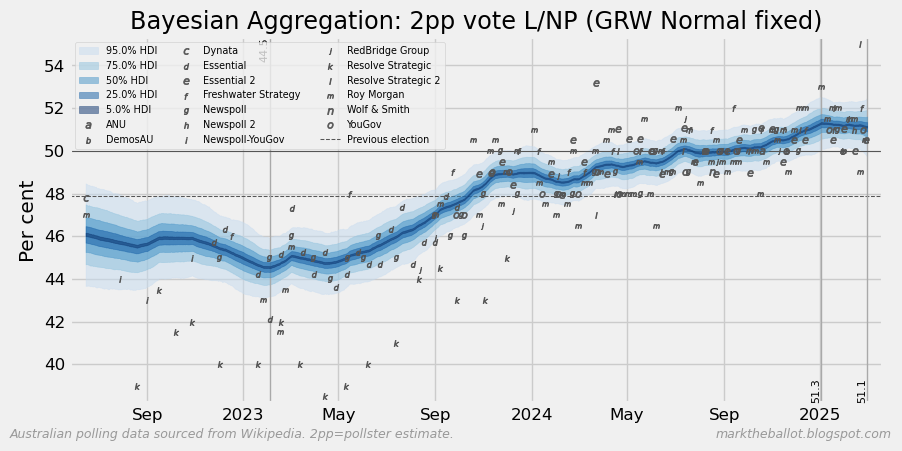

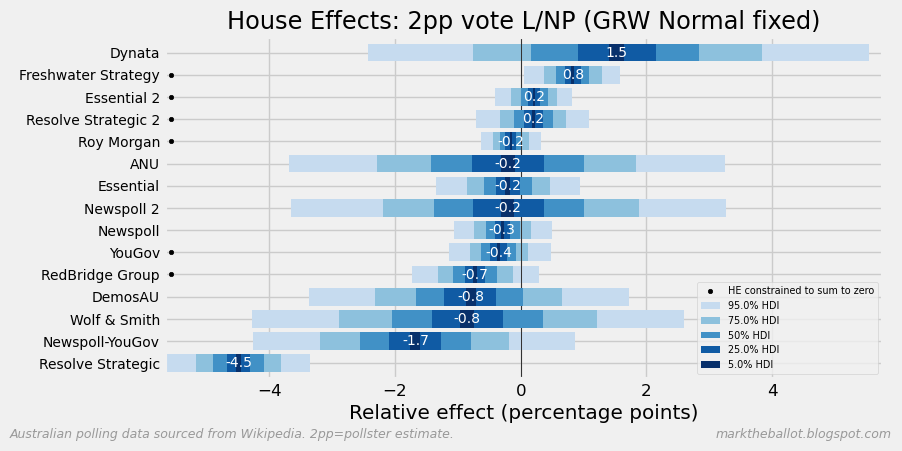

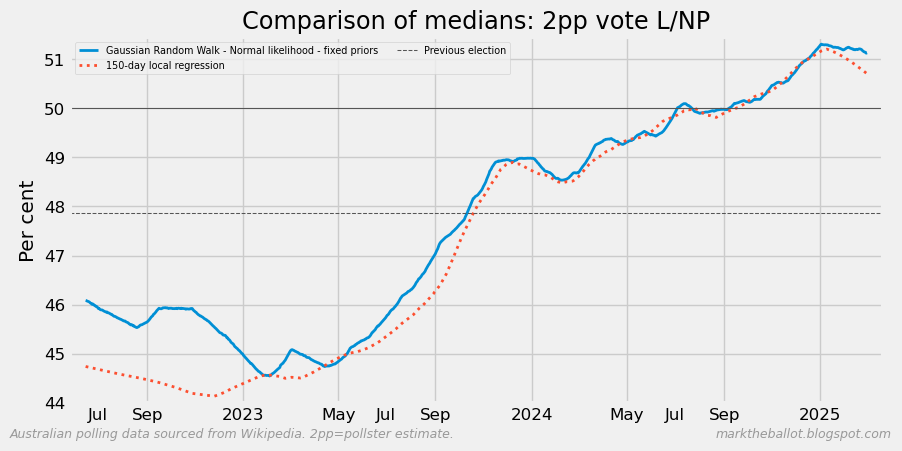

Primary vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2705.0
Divergences: 0


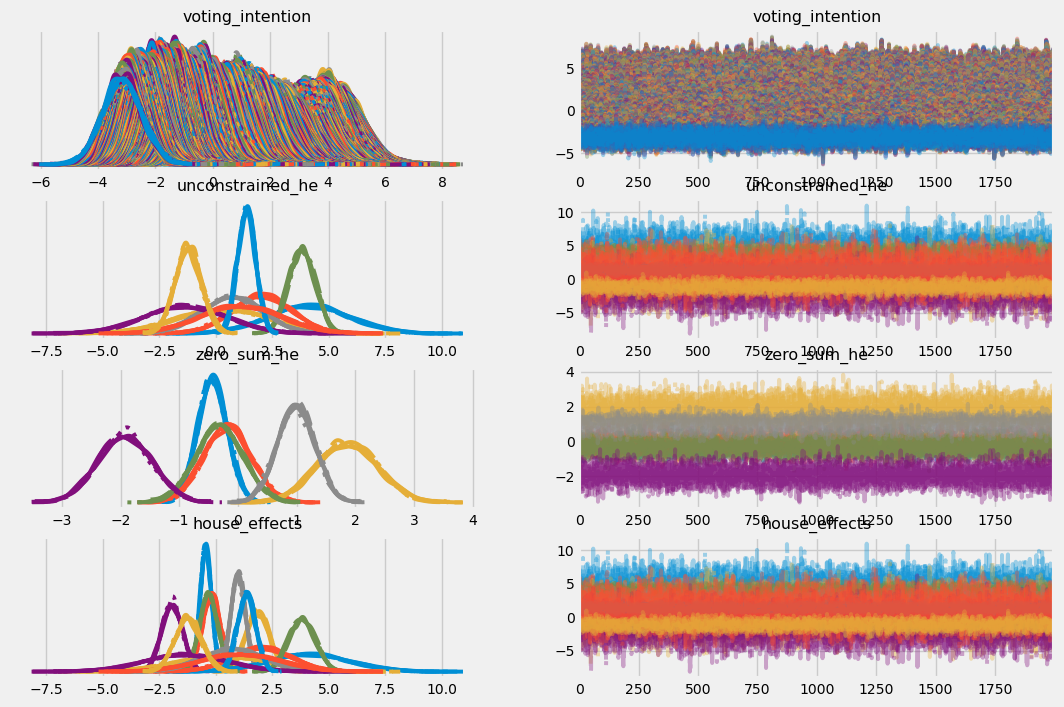

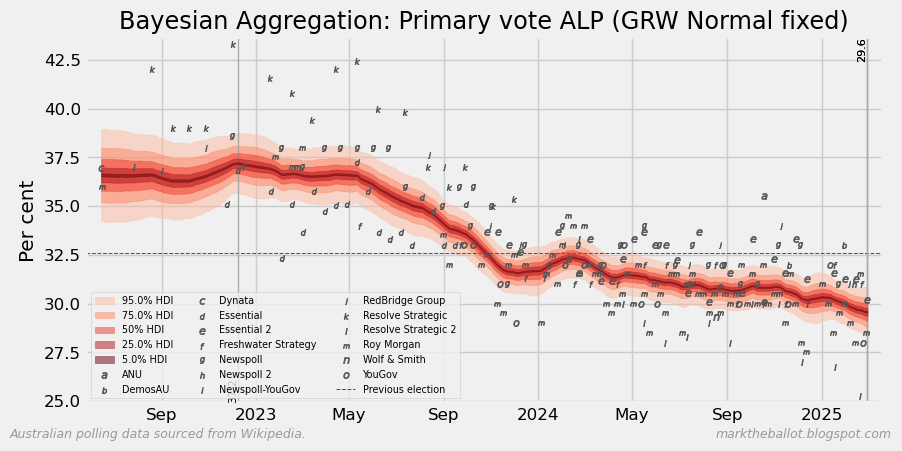

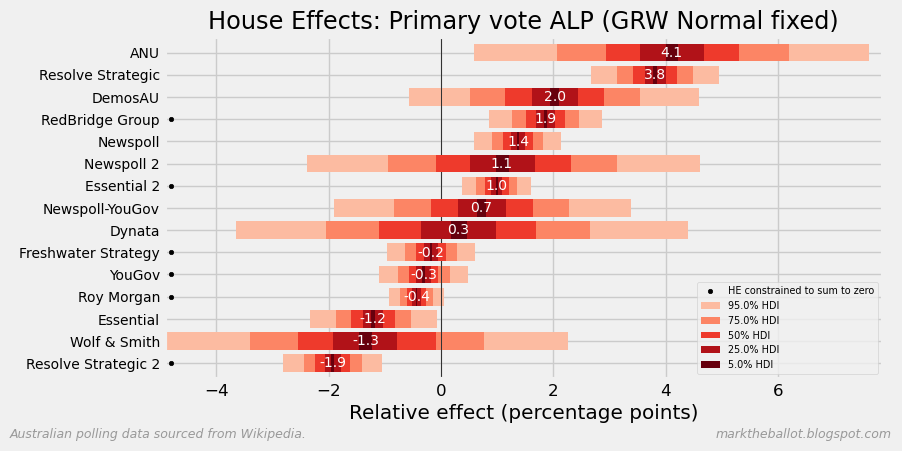

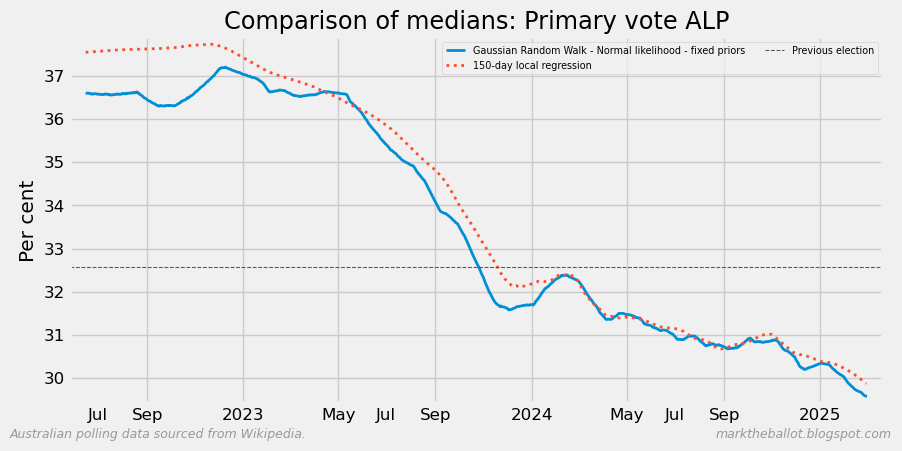

Primary vote GRN (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2670.0
Divergences: 0


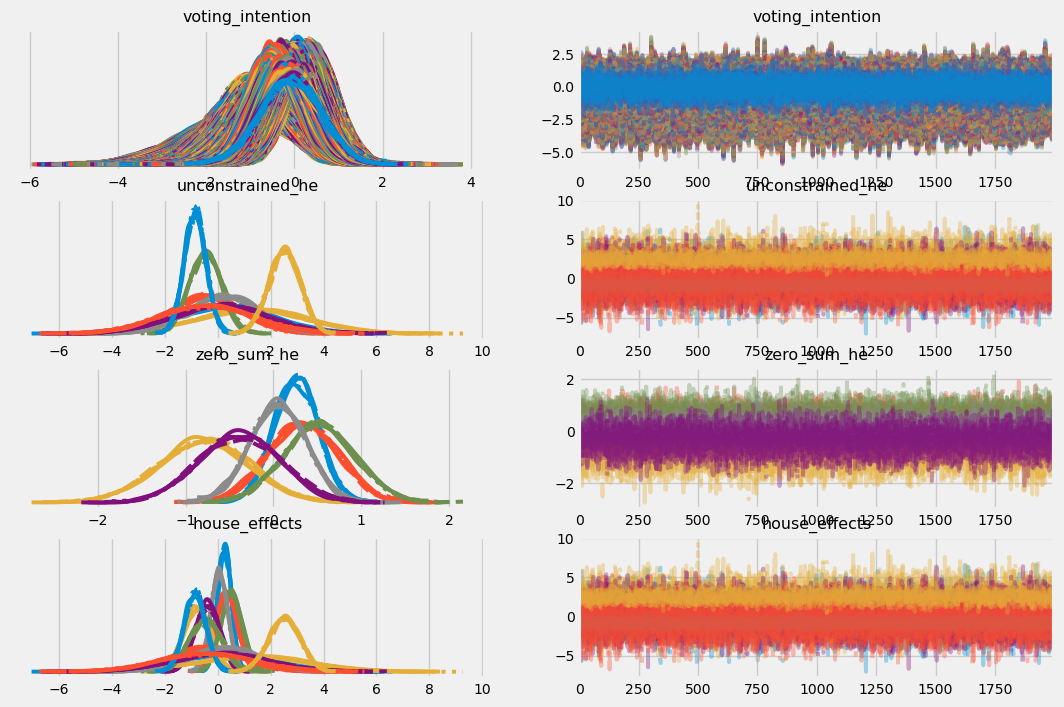

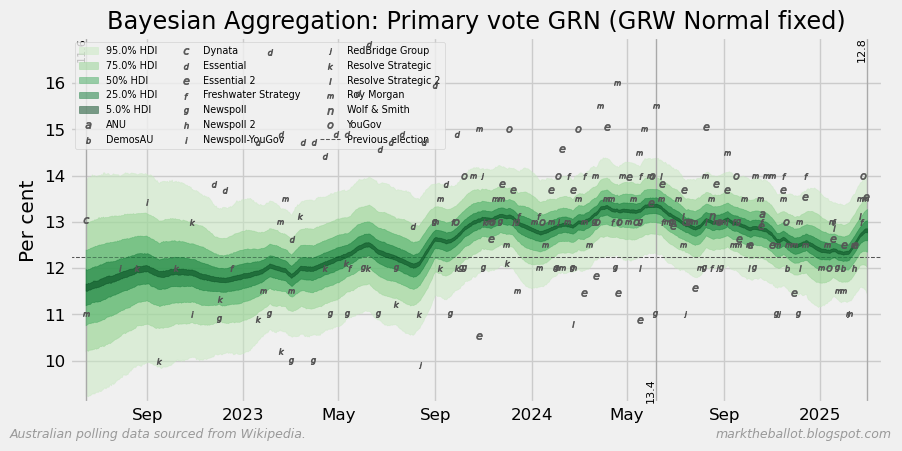

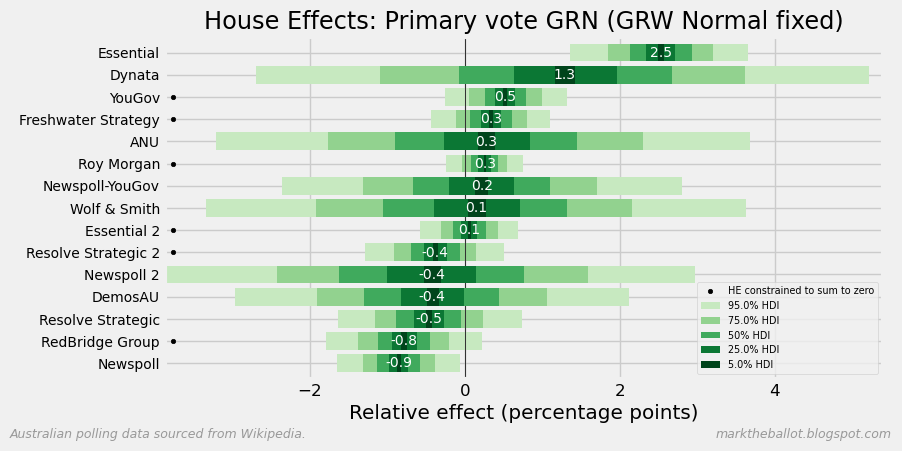

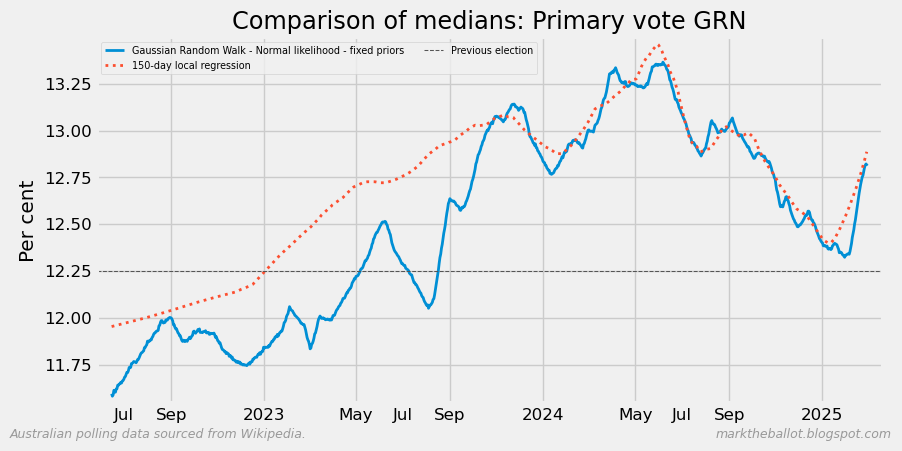

Primary vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2639.0
Divergences: 0


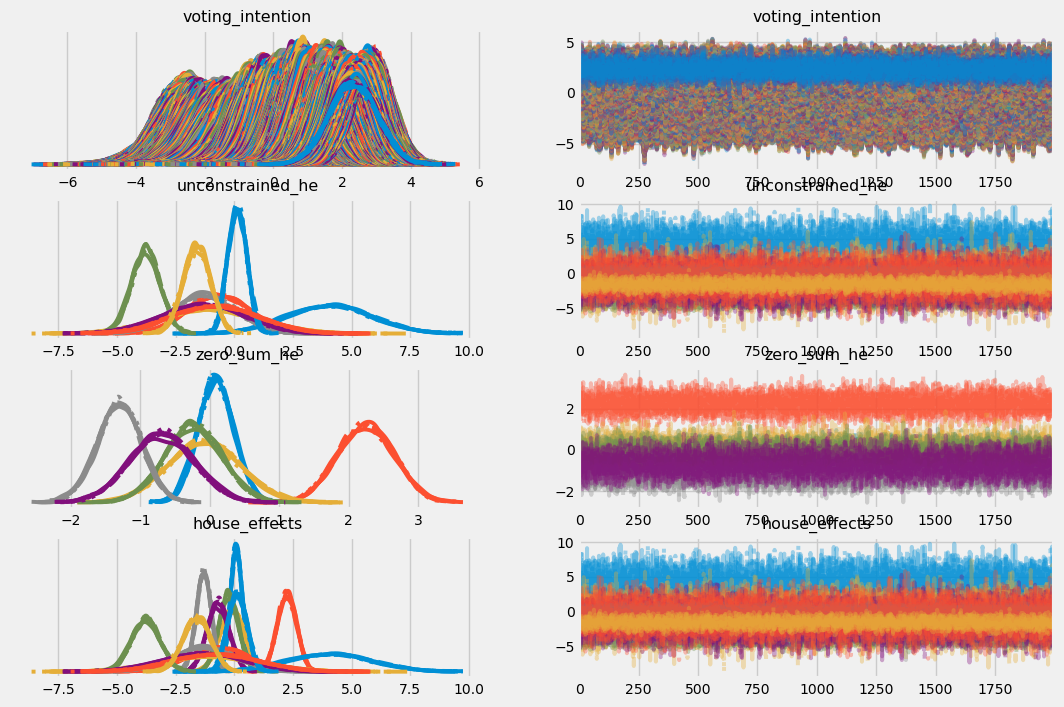

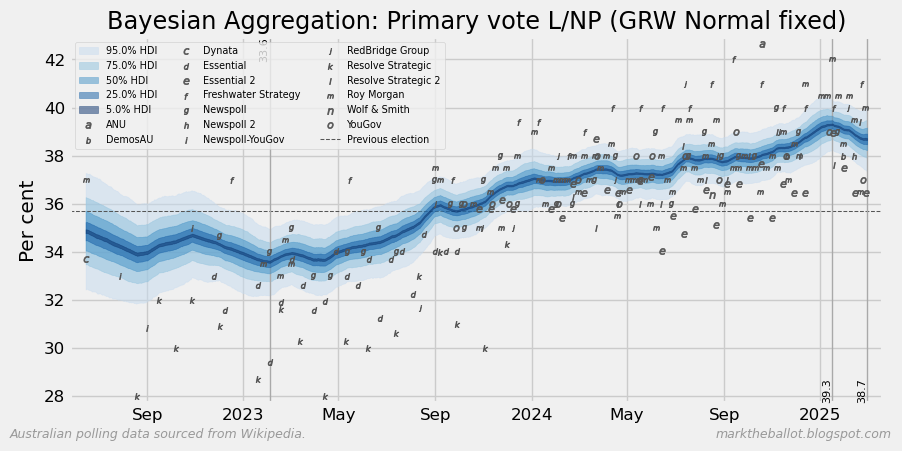

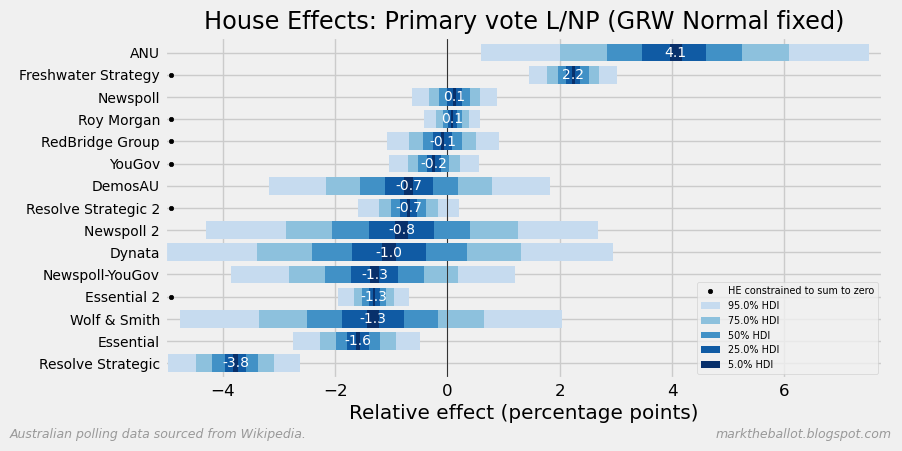

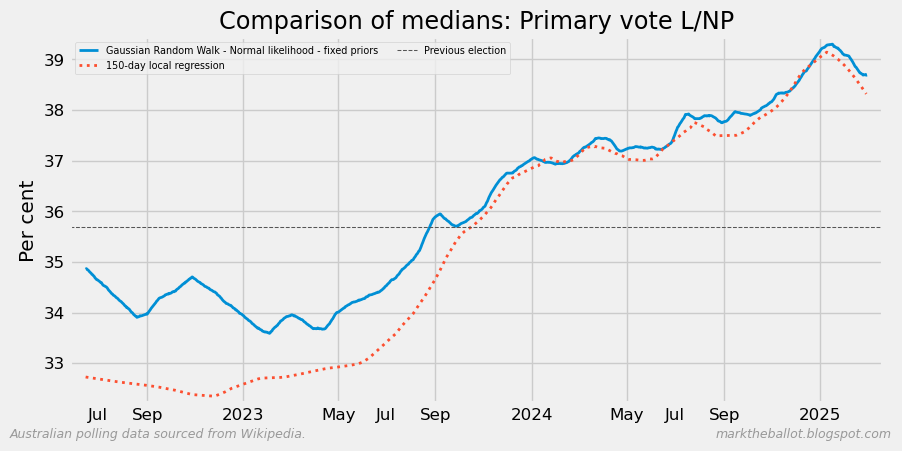

Primary vote Other (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2968.0
Divergences: 0


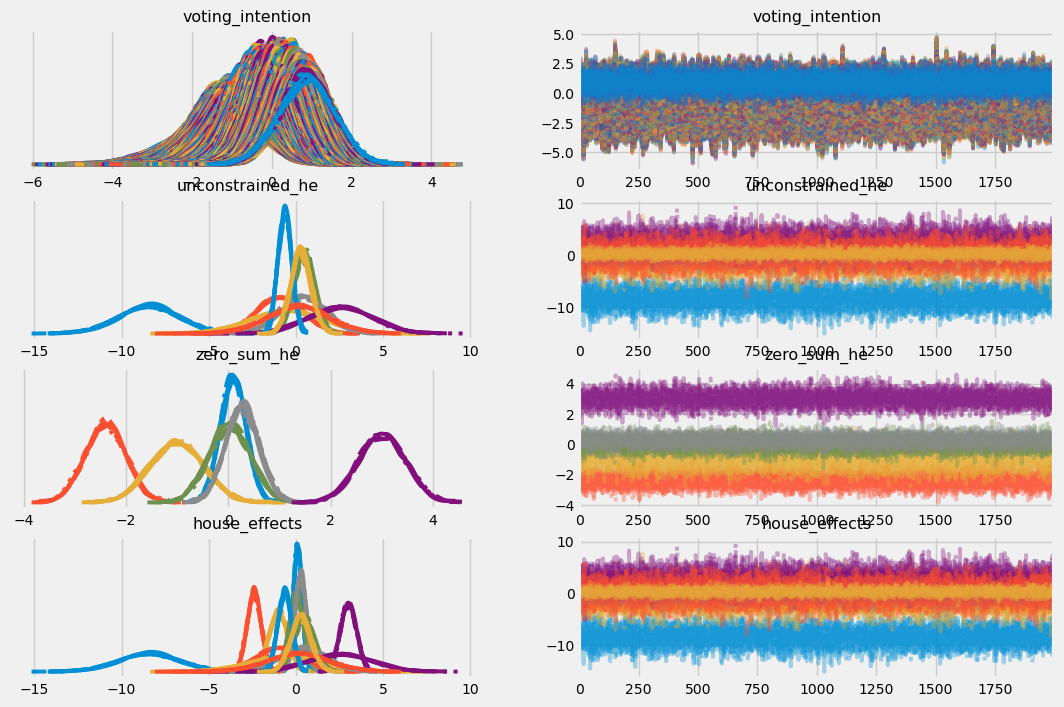

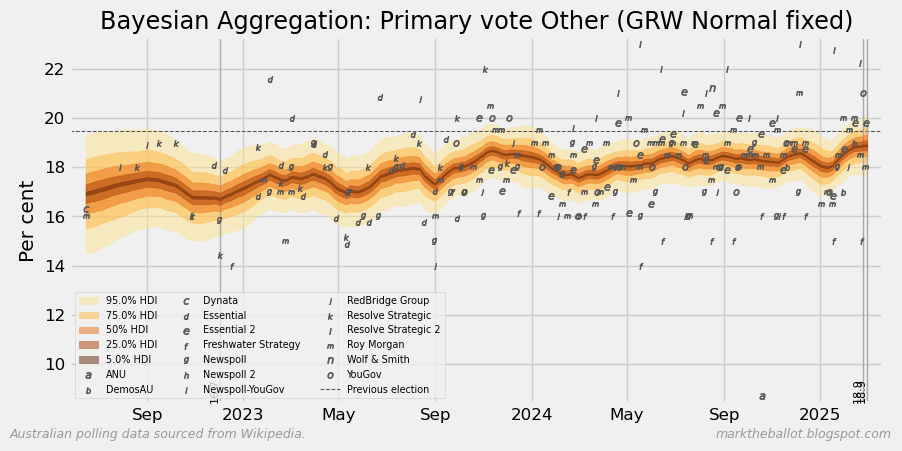

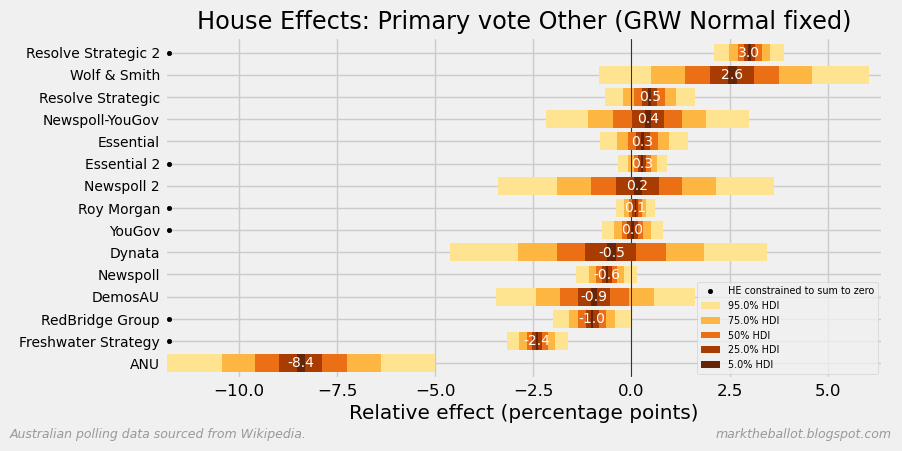

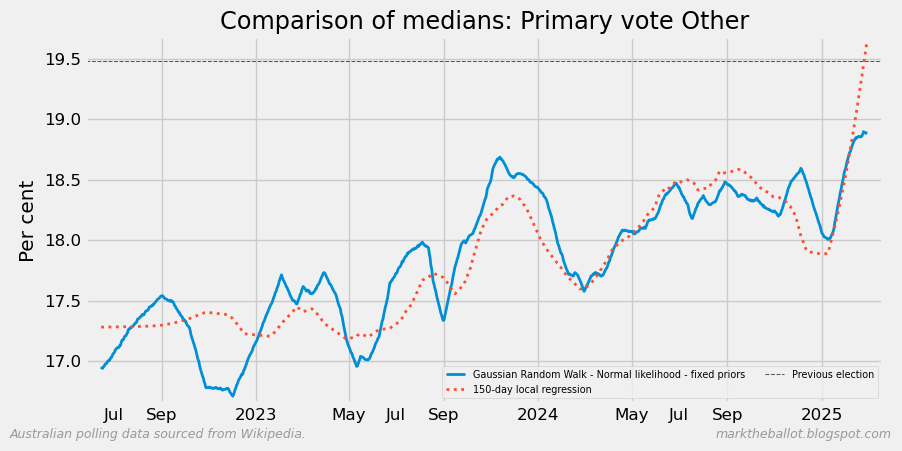

TPP vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2477.0
Divergences: 0


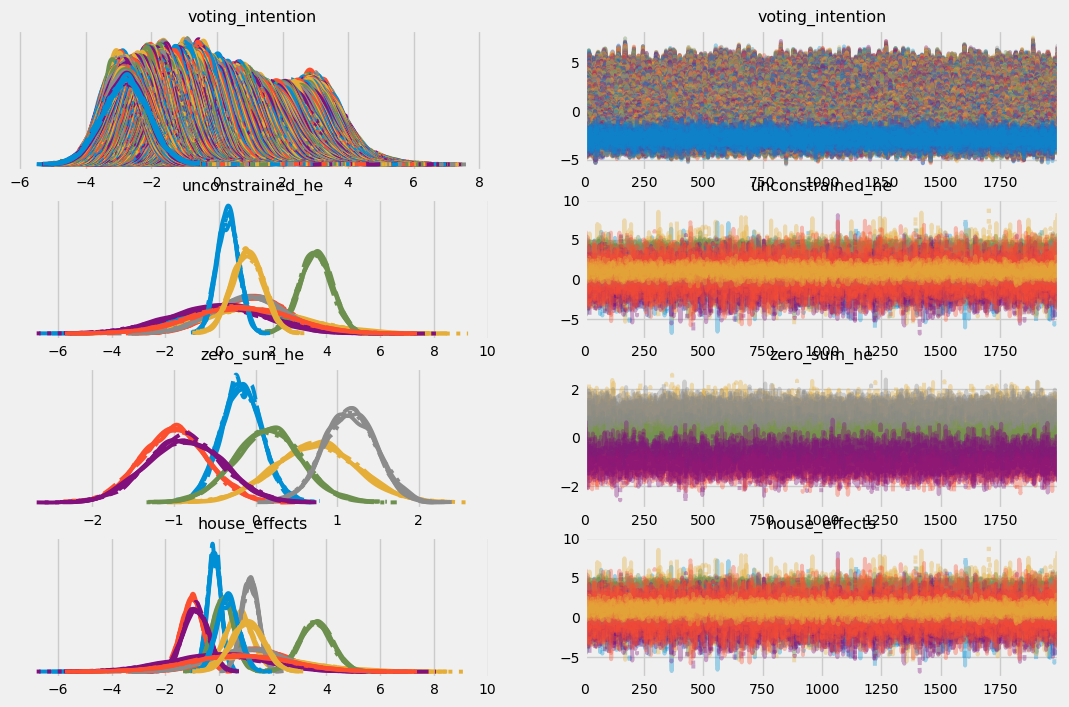

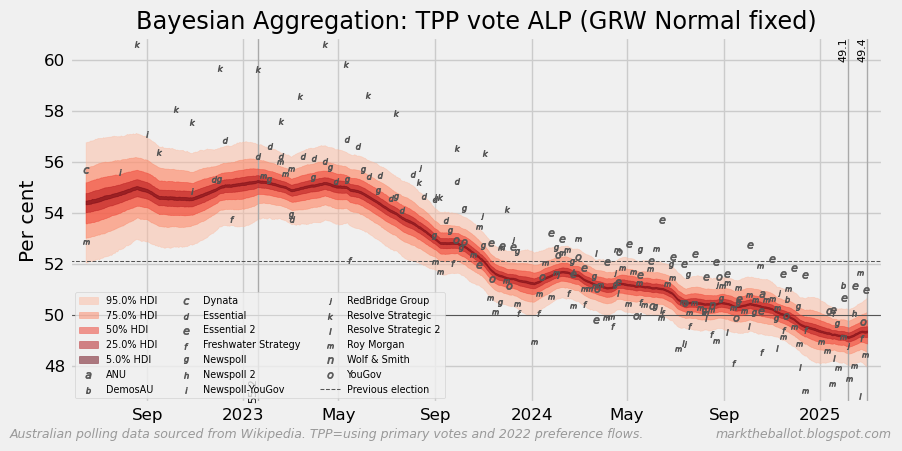

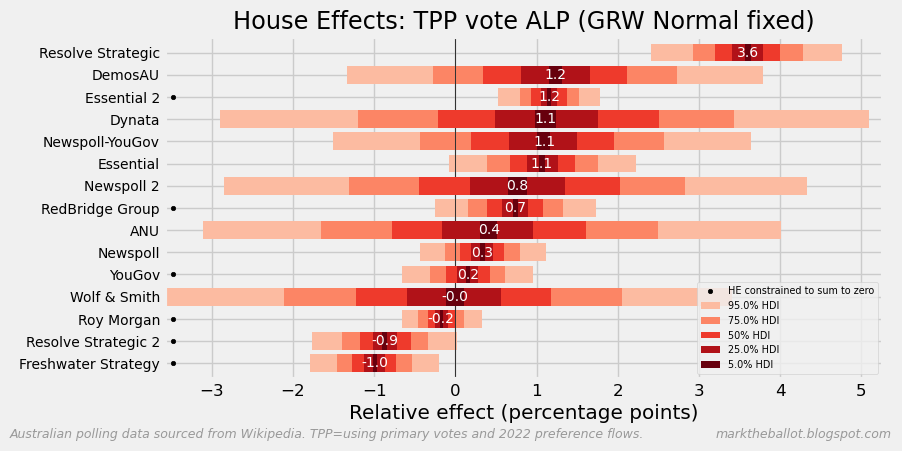

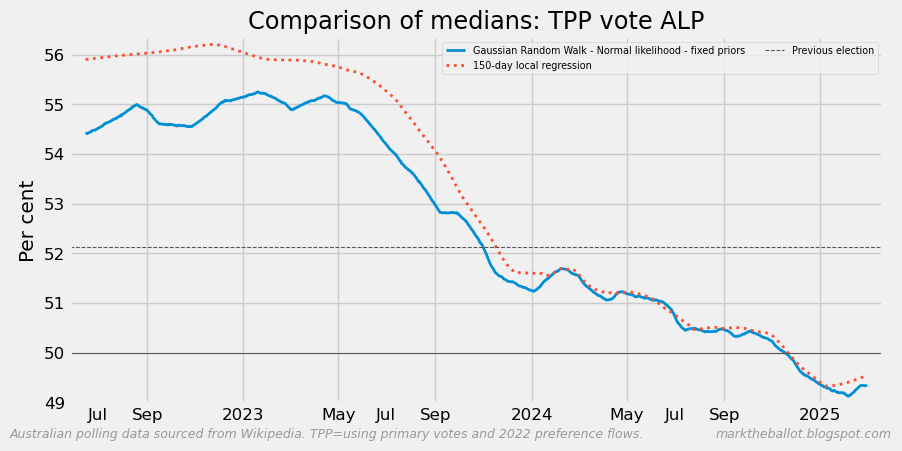

TPP vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3038.0
Divergences: 0


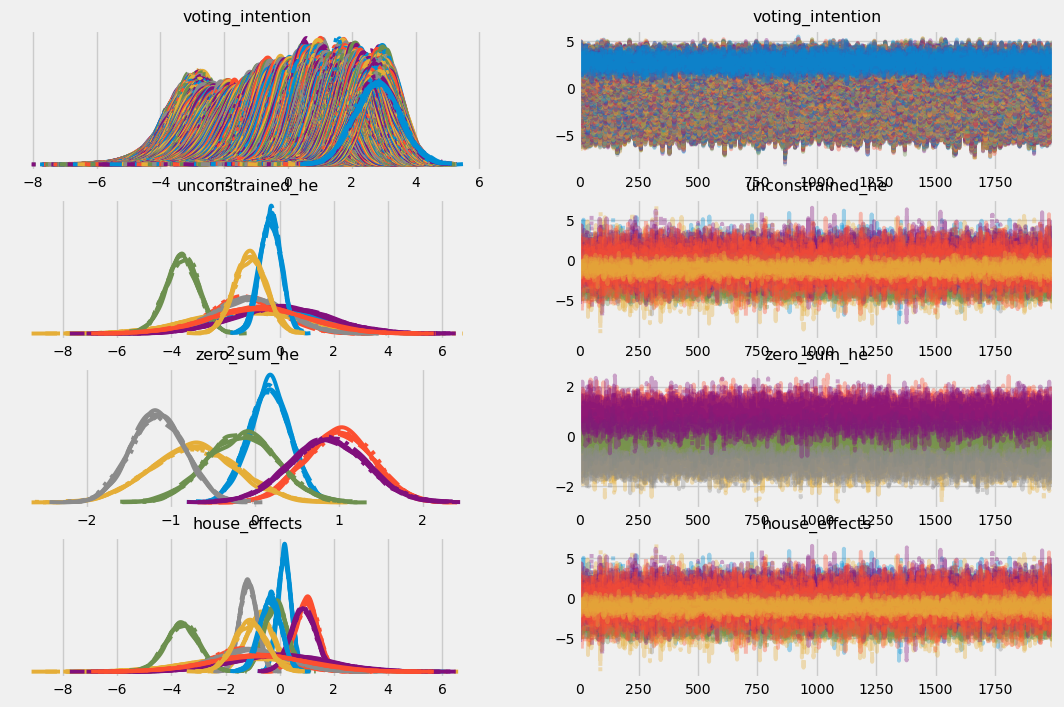

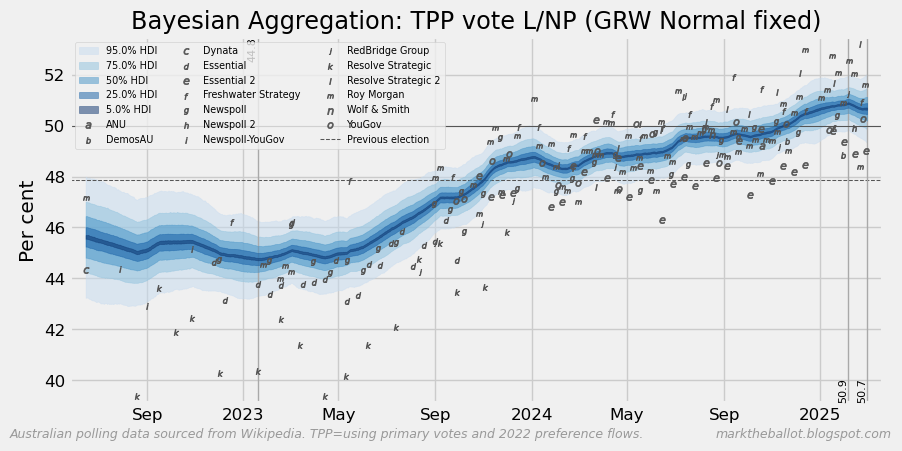

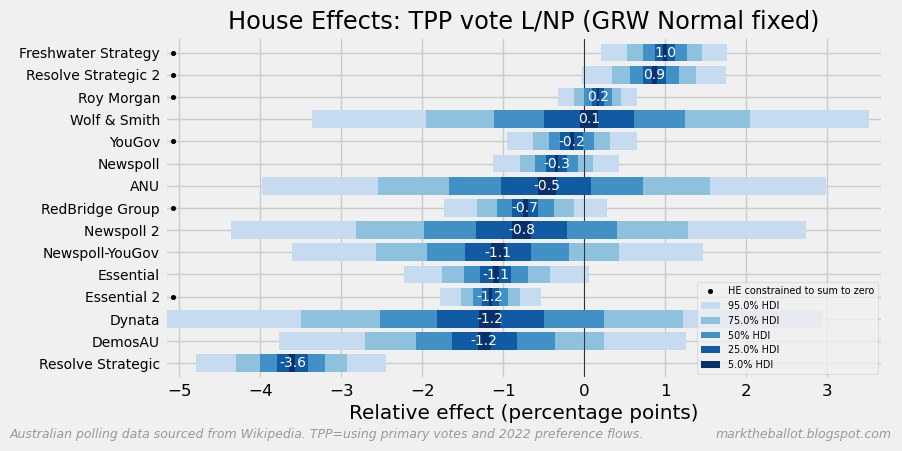

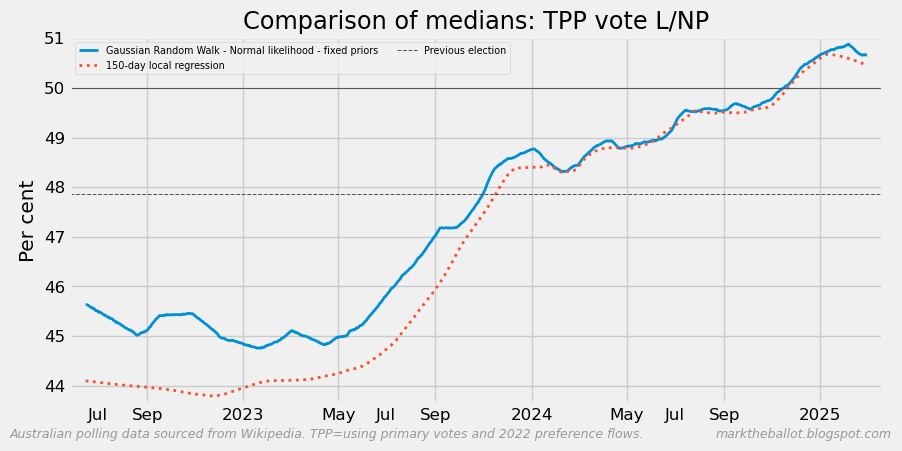

2pp vote ALP  \
Gaussian Random Walk - Normal likelihood - fixe...         48.87   
150-day local regression                                   49.28   

                                                    2pp vote L/NP  \
Gaussian Random Walk - Normal likelihood - fixe...          51.13   
150-day local regression                                    50.72   

                                                    Primary vote ALP  \
Gaussian Random Walk - Normal likelihood - fixe...             29.58   
150-day local regression                                       29.87   

                                                    Primary vote GRN  \
Gaussian Random Walk - Normal likelihood - fixe...             12.82   
150-day local regression                                       12.89   

                                                    Primary vote L/NP  \
Gaussian Random Walk - Normal likelihood - fixe...              38.69   
150-day local regression                                        38.32   

                                                    Primary vote Other  \
Gaussian Random Walk - Normal likelihood - fixe...               18.89   
150-day local regression                                         19.62   

                                                    TPP vote ALP  \
Gaussian Random Walk - Normal likelihood - fixe...         49.35   
150-day local regression                                   49.54   

                                                    TPP vote L/NP  
Gaussian Random Walk - Normal likelihood - fixe...          50.67  
150-day local regression                                    50.46

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>2pp vote ALP</th>
      <th>2pp vote L/NP</th>
      <th>Primary vote ALP</th>
      <th>Primary vote GRN</th>
      <th>Primary vote L/NP</th>
      <th>Primary vote Other</th>
      <th>TPP vote ALP</th>
      <th>TPP vote L/NP</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Gaussian Random Walk - Normal likelihood - fixed priors</th>
      <td>48.87</td>
      <td>51.13</td>
      <td>29.58</td>
      <td>12.82</td>
      <td>38.69</td>
      <td>18.89</td>
      <td>49.35</td>
      <td>50.67</td>
    </tr>
    <tr>
      <th>150-day local regression</th>
      <td>49.28</td>
      <td>50.72</td>
      <td>29.87</td>
      <td>12.89</td>
      <td>38.32</td>
      <td>19.62</td>
      <td>49.54</td>
      <td>50.46</td>
    </tr>
  </tbody>
</table>


In [17]:
def run() -> None:
    """Run the analysis."""

    # data preparation
    data_dict = data_check(retrieve())
    vi_data = plotting.amalgamate_other(
        df=data_dict[VOTING_INTENTION]
    )  # important for establishing the "Others" category
    vi_data["TPP vote ALP"] = (
        vi_data["Primary vote ALP"]
        + vi_data["Primary vote GRN"] * GREEN_FLOW
        + vi_data["Primary vote Other"] * OTHER_FLOW
    )
    vi_data["TPP vote L/NP"] = 100 - vi_data["TPP vote ALP"]

    # main arguments
    selected_analysis = select_analytic_modality()
    selected_columns = select_columns(vi_data)

    # additional arguments
    sample_args, anchored_sample_args = sample_settings()

    analyse_columns(
        selected_columns,
        selected_analysis,
        vi_data,
        previous_election=last_election(),
        fixed_priors_dict=establish_fixed_priors(),
        sample_args=sample_args,
        anchored_sample_args=anchored_sample_args,
        he_sum_exclusions=establish_exclusions(vi_data),
        plot_residuals=False,
    )


run()

## Estimate 2pp using 2022 preference flows

In [18]:
def plot_normed_primary(n: pd.DataFrame, modality: str) -> None:
    """Plot the normed primary vote medians."""

    def color_name(t):
        match t.split():
            case [*_, "ALP"]:
                return "#dd0000", 'Labor'
            case [*_, "L/NP"]:
                return "blue", 'Coalition'
            case [*_, "GRN"]:
                return "green", 'Greens'
            case _:
                return "darkorange", 'Others'
    names = [color_name(x)[1] for x in n.columns]
    colors = [color_name(x)[0] for x in n.columns]

    # plot the normed primary votes: Coalition, Labor, Greens, Others
    normed_p = n * 100
    normed_p.columns = names
    ax = (normed_p).plot(lw=3, color=colors)
    for value in normed_p.iloc[-1]:
        ax.text(
            normed_p.index[-1],
            value,
            f" {value:.1f}",
            color="#444444",
            ha="left",
            va="center",
            fontsize="small",
        )
    for name, value in normed_p.iloc[-1].items():
        ax.text(
            normed_p.index[-1],
            value-0.5 if name != "Greens" else value+0.5,
            f"{name} ",
            color="#444444",
            ha="right",
            va="top" if name != "Greens" else "bottom",
            fontsize="small",
        )
    plotting.finalise_plot(
        ax,
        title=f"Bayesian aggregation of primary votes: {modality}",
        ylabel="Per cent",
        y50=True,
        concise_dates=True,
        straighten_tl=True,
        rfooter=plotting.footers["rfooter"],
        lfooter=plotting.footers["lfooter"]
        + "Medians from Bayesian aggregation. ",
        show=SHOW,
        legend={"loc": "center left", "fontsize": "x-small"},
    )

    # major and minor parties
    groups = {"Major": ["Coalition", "Labor"], "Minor": ["Greens", "Others"]}
    for group, members in groups.items():
        color = {"Major": "purple", "Minor": "teal"}[group]
        series = normed_p[members].sum(axis=1)
        ax = series.plot(lw=3, color=color)
        ax.text(
            series.index[-1],
            series.iloc[-1],
            f" {series.iloc[-1]:.1f}",
            color="#444444",
            ha="left",
            va="center",
            fontsize="small",
        )
        plotting.finalise_plot(
            ax,
            title=f"Bayesian aggregation of {group} parties: {modality}",
            ylabel="Per cent",
            concise_dates=True,
            rfooter=plotting.footers["rfooter"],
            lfooter=plotting.footers["lfooter"]
            + f"Medians from Bayesian aggregation {members}. ",
            show=SHOW,
        )
    

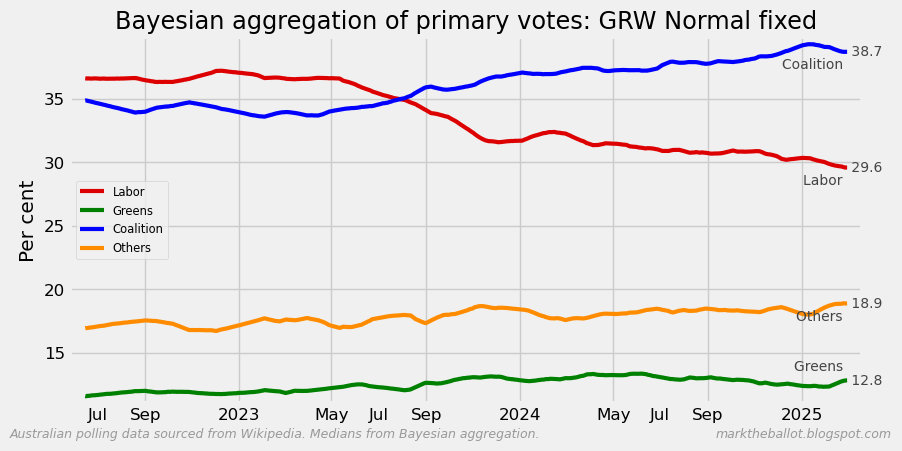

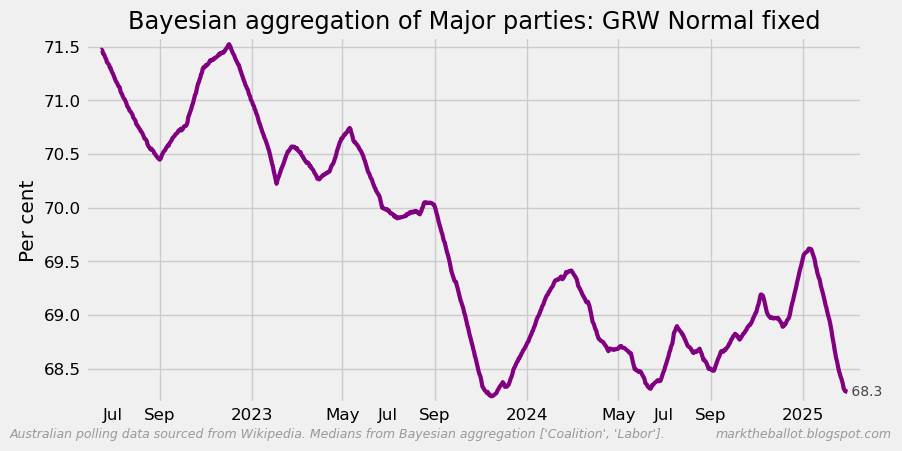

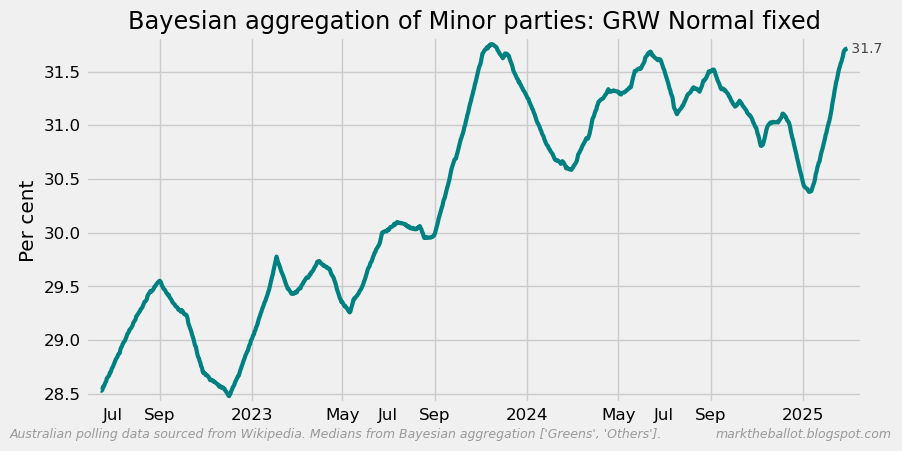

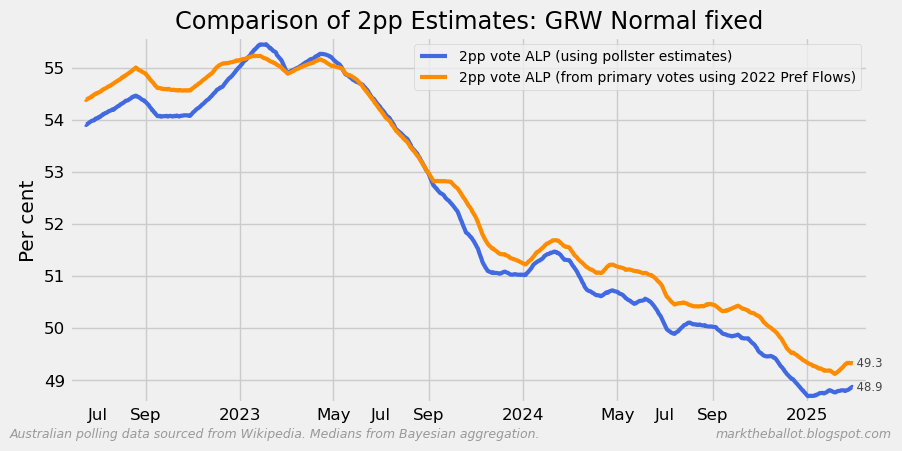

In [19]:
def tpp_from_primary():
    """Estimate 2pp from primary votes using 2022 preference flows."""

    analytic_modes = {}
    # group the data by analytic mode
    for key, value in DATA_REPOSITORY.items():
        party = re.findall(r"^[^(]+", key)[0].strip()
        mode = re.findall(r"\((.*?)\)", key)[0].strip()
        if mode not in analytic_modes:
            analytic_modes[mode] = pd.DataFrame()
        analytic_modes[mode][party] = value

    # make and plot the 2pp estimates
    for modality in analytic_modes.keys():
        # make the estimate
        df = analytic_modes[modality]
        primary = [col for col in df.columns if col.startswith("Primary")]
        if len(primary) != 4:
            print(f"Skipping {modality} as it has {len(primary)} primary columns.")
            continue

        labor = [col for col in primary if "ALP" in col][0]
        green = [col for col in primary if "GRN" in col][0]
        other = [col for col in primary if "Other" in col][0]
        if len(primary) != 4:
            continue
        total = df[primary].sum(axis=1)
        normed = df[primary].div(total, axis=0)  # on the simplex
        plot_normed_primary(normed, modality)

        df["2pp vote ALP (from primary votes using 2022 Pref Flows)"] = (
            normed[labor] + normed[green] * GREEN_FLOW + normed[other] * OTHER_FLOW
        ) * 100
        df = df.rename(
            columns={"2pp vote ALP": "2pp vote ALP (using pollster estimates)"}
        )
        tpp = [col for col in df.columns if "2pp vote ALP" in col]

        # plot the estimate
        ax = df[tpp].plot(lw=3, color=["royalblue", "darkorange"])
        for x in df[tpp].iloc[-1]:
            ax.text(
                df.index[-1],
                x,
                f" {x:.1f}",
                color="#444444",
                ha="left",
                va="center",
                fontsize="x-small",
            )
        plotting.finalise_plot(
            ax,
            title=f"Comparison of 2pp Estimates: {modality}",
            ylabel="Per cent",
            concise_dates=True,
            rfooter=plotting.footers["rfooter"],
            lfooter=plotting.footers["lfooter"]
            + "Medians from Bayesian aggregation. ",
            show=SHOW,
            legend={"loc": "best", "fontsize": "small"},
        )


tpp_from_primary()

## Finished

In [20]:
print("Finished")

Finished
